In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandasdmx as sdmx
from functools import reduce

/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/site-packages/pandasdmx/remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


# Data Fetching & Basic Manipulation

In [4]:
estat = sdmx.Request("ESTAT")

## Carbon Data

In [5]:
resp = estat.data(
	"ENV_AIR_GGE",
	key={
		"unit": "THS_T",
		"freq": "A",
		"src_crf": "TOTX4_MEMONIA",
		"airpol": "GHG"
	}
)
emission_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD'}).droplevel(level=['unit', 'freq', 'src_crf', 'airpol'], axis=1)
emission_df.reset_index(inplace=True)
emission_df["year"] = emission_df["TIME_PERIOD"].dt.year
emission_df.drop("TIME_PERIOD", inplace=True, axis=1)
emission_melted_df = pd.melt(emission_df, id_vars="year")

emission_melted_df.head()

2024-06-06 01:29:44,221 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


,year,geo,value
0,1985,AT,NaN
1,1986,AT,NaN
2,1987,AT,NaN
3,1988,AT,NaN
4,1989,AT,NaN


## Energy Data

In [6]:
def get_melted_energy_dfs(code: str) -> pd.DataFrame:
	"""
	A quick helper to get, parse, and melt the dataframes for a given energy `nrg_bal`.

	:param code: The `nrg_bal` code to fetch and melt
	:returns: A melted dataframe
	"""
	resp = estat.data(
		"NRG_D_HHQ",
		key={
			"siec": "TOTAL",
			"unit": "TJ",
			"nrg_bal": code,
			"freq": "A",
		}
	)
	household_energy_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD', 'freq': 'freq'}).droplevel(level=["siec", "unit", "nrg_bal"], axis=1)

	household_energy_df.reset_index(inplace=True)
	household_energy_df["year"] = household_energy_df["TIME_PERIOD"].dt.year
	household_energy_df.drop("TIME_PERIOD", inplace=True, axis=1)
	household_energy_melted_df = pd.melt(household_energy_df, id_vars="year")
	household_energy_melted_df.columns = ["year", "geo", code]
	return household_energy_melted_df

In [7]:
codes = ["FC_OTH_HH_E_SH", "FC_OTH_HH_E_SC", "FC_OTH_HH_E_WH", "FC_OTH_HH_E_CK", "FC_OTH_HH_E"]
energy_dfs = [get_melted_energy_dfs(code) for code in codes]

2024-06-06 01:29:45,509 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  return dispatch(args[0].__class__)(*args, **kw)
2024-06-06 01:29:45,631 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  return dispatch(args[0].__class__)(*args, **kw)
2024-06-06 01:29:45,836 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
/opt/homebrew/Caskroom/miniconda/base/envs/wafflers/lib/python3.11/functools.py:909: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' ins

In [8]:
resp = estat.data(
	"TEN00127",
	key={
		"unit": "KTOE",
		"freq": "A",
		"siec": "O4652XR5210B",
		"nrg_bal": "FC_TRA_ROAD_E"
	}
)
gas_df = resp.to_pandas(datetime={'dim': 'TIME_PERIOD'}).droplevel(level=['unit', 'freq', 'siec', "nrg_bal"], axis=1)
gas_df.reset_index(inplace=True)
gas_df["year"] = gas_df["TIME_PERIOD"].dt.year
gas_df.drop("TIME_PERIOD", inplace=True, axis=1)
gas_melted_df = pd.melt(gas_df, id_vars="year")

gas_melted_df.head()

2024-06-06 01:29:47,302 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


,year,geo,value
0,2011,AL,115.592
1,2012,AL,100.745
2,2013,AL,109.229
3,2014,AL,109.229
4,2015,AL,109.229


## Merge Datasets

In [9]:
to_merge_dfs = [emission_melted_df, *energy_dfs, gas_melted_df]
columns = ["year", "geo", "carbon", "energy_heating", "energy_cooling", "energy_water_heating", "energy_cooking", "household_total", "gas"]
res_carbon_df = reduce(lambda l, r: pd.merge(l, r, left_on=["year", "geo"], right_on=["year", "geo"]), to_merge_dfs)
res_carbon_df.columns = columns
res_carbon_df.head()

,year,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas
0,2011,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.260
1,2012,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,2013,AT,82304.13,205494.885,31.035,41541.823,7353.560,289591.863,1554.830
3,2014,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,2015,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


In [10]:
res_carbon_df.head()

,year,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas
0,2011,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.260
1,2012,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,2013,AT,82304.13,205494.885,31.035,41541.823,7353.560,289591.863,1554.830
3,2014,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,2015,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


In [11]:
res_carbon_df.iloc[:, 2:].corr()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas
carbon,1.000000,0.953869,0.860313,0.953779,0.958319,0.955914,0.996808
energy_heating,0.953869,1.000000,0.927161,0.994903,0.993174,0.999384,0.957200
energy_cooling,0.860313,0.927161,1.000000,0.927569,0.933307,0.932779,0.871504
energy_water_heating,0.953779,0.994903,0.927569,1.000000,0.994355,0.996931,0.958940
energy_cooking,0.958319,0.993174,0.933307,0.994355,1.000000,0.995192,0.960886
household_total,0.955914,0.999384,0.932779,0.996931,0.995192,1.000000,0.959322
gas,0.996808,0.957200,0.871504,0.958940,0.960886,0.959322,1.000000


In [14]:
import matplotlib.cm as cm

Text(0, 0.5, 'Greenhouse Gas Emissions (ktonne CO2 equivelent)')

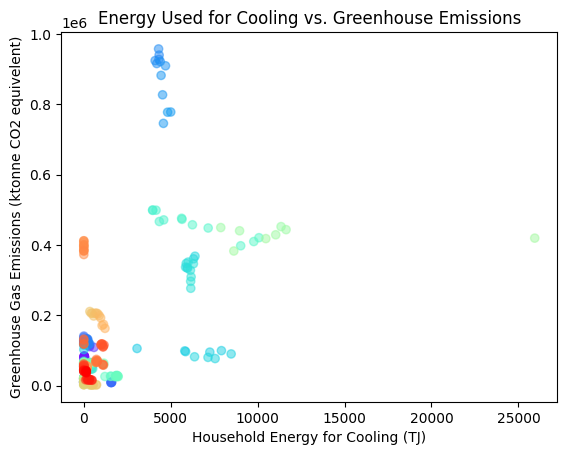

In [24]:
colors = cm.rainbow(np.linspace(0, 1, len(res_carbon_df)))
plt.scatter(x=res_carbon_df["energy_cooling"], y=res_carbon_df["carbon"], color=colors, alpha=0.5)
plt.title("Energy Used for Cooling vs. Greenhouse Emissions")
plt.xlabel("Household Energy for Cooling (TJ)")
plt.ylabel("Greenhouse Gas Emissions (ktonne CO2 equivelent)")


In [22]:
res_carbon_df.drop(res_carbon_df[(res_carbon_df.geo == "EU27_2020") | (res_carbon_df.geo == "EU20")].index, inplace=True)

In [25]:
res_carbon_df.drop("year", axis=1, inplace=True)

## Missing Data

In [26]:

def fill_holes():
	"""
	"""
	lin_reg = lambda X, Y: np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

	dfs = []

	for name, group in res_carbon_df.groupby('geo'):
		cols = [[name for _ in range(len(group.index))]]
		for i in range(1, len(group.columns)):
			d = group.iloc[:, i:i+1].to_numpy()

			missing_mask = np.isnan(d) | (d == 0)
			present_mask = ~missing_mask

			missing_mask = missing_mask.reshape(1, -1)[0]
			present_mask = present_mask.reshape(1, -1)[0]

			if not np.any(missing_mask):
				d = d.reshape(1, -1)[0]
				cols.append(d)
				continue

			if not np.any(present_mask):
				d = d.reshape(1, -1)[0]
				cols.append(d)
				continue

			x_present = np.pad(np.arange(len(d))[present_mask].reshape(-1, 1), ((0, 0), (1, 0)), mode="constant", constant_values=1)
			y_present = d[present_mask]

			w = lin_reg(x_present, y_present)

			x_missing = np.pad(np.arange(len(d))[missing_mask].reshape(-1, 1), ((0, 0), (1, 0)), mode="constant", constant_values=1)
			y_missing_pred = np.matmul(x_missing, w)

			d[missing_mask] = y_missing_pred
			d = d.reshape(1, -1)[0]

			cols.append(d)
		# print(cols)
		dfs.append(pd.DataFrame(cols).T)	
		# print(dfs)
	df = pd.concat(dfs, axis=0)
	df.columns = res_carbon_df.columns
	return df

res_carbon_df = fill_holes()
res_carbon_df.head()

,geo,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas
0,AT,84795.76,190731.846,25.123,41343.612,6891.695,274577.058,1632.26
1,AT,81981.39,195419.278,34.215,41839.251,7026.774,279812.556,1585.826
2,AT,82304.13,205494.885,31.035,41541.823,7353.56,289591.863,1554.83
3,AT,78716.82,178513.717,27.645,42495.391,7152.047,261676.431,1524.254
4,AT,81081.58,193886.979,25.714,42104.965,7179.133,278096.422,1539.983


## Standardize

In [27]:
df_merged_s = pd.DataFrame()
for feat in res_carbon_df.columns:
	if feat == "geo": continue
	df_merged_s[f'{feat}'] = ((res_carbon_df[feat] - res_carbon_df[feat].mean()) / res_carbon_df[feat].std())
df_merged_s["geo"] = res_carbon_df["geo"]
# df_merged_s["year"] = res_carbon_df["year"]
df_merged_s.head()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas,geo
0,-0.277234,-0.150436,-0.519111,-0.165819,-0.442083,-0.193489,-0.208284,AT
1,-0.291775,-0.137877,-0.515819,-0.159561,-0.438278,-0.183995,-0.22177,AT
2,-0.290107,-0.110884,-0.51697,-0.163316,-0.429072,-0.166262,-0.230772,AT
3,-0.308642,-0.183169,-0.518198,-0.151277,-0.434749,-0.216883,-0.239653,AT
4,-0.296424,-0.141983,-0.518897,-0.156206,-0.433986,-0.187107,-0.235084,AT


## Dummies

In [29]:
df_dummies = pd.get_dummies(df_merged_s, dtype=int, columns=["geo"])
print(df_dummies.shape)
df_dummies.head()

(336, 35)


,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,household_total,gas,geo_AT,geo_BE,geo_BG,...,geo_LV,geo_MT,geo_NL,geo_NO,geo_PL,geo_PT,geo_RO,geo_SE,geo_SI,geo_SK
0,-0.277234,-0.150436,-0.519111,-0.165819,-0.442083,-0.193489,-0.208284,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.291775,-0.137877,-0.515819,-0.159561,-0.438278,-0.183995,-0.22177,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.290107,-0.110884,-0.51697,-0.163316,-0.429072,-0.166262,-0.230772,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.308642,-0.183169,-0.518198,-0.151277,-0.434749,-0.216883,-0.239653,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.296424,-0.141983,-0.518897,-0.156206,-0.433986,-0.187107,-0.235084,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_dummies = df_dummies.fillna(0)

/var/folders/jk/vqmr1l1d1dnflmyh1qdjmhk40000gn/T/ipykernel_97545/3693932479.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies = df_dummies.fillna(0)


In [31]:
df_dummies.drop(["energy_cooling", "energy_heating", "energy_water_heating", "energy_cooking"], axis=1, inplace=True)

## Linear Regression

In [43]:
X = np.pad(df_dummies.iloc[:, 1:].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1)
y = np.array(df_dummies["carbon"])
X[56:58,]

array([[ 1.        , -0.15506195, -0.21718148,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.        , -0.14198966, -0.25949037,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [44]:
m = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, y))
np.set_printoptions(suppress=True) #this just prevents python from printing it out in inconvenient scientific notation
m

array([  4.88508124,  11.90934986,   4.345609  ,  -4.94743023,
        -3.93159802,  -0.56534299,   1.50409325,  -3.03722218,
       -66.98241677,  -3.2859403 ,   2.73019393,  -1.59730943,
       -14.18092016,  -5.02689332, -38.15626913,  -0.97102755,
        -4.95647721,   1.94370399, -34.24900068,   1.07903285,
         0.81998587,   2.20177111,   4.81320064, -10.74424902,
        -2.00751748, -17.99937653,   1.31870399,  -3.93838325,
        -6.4031752 ,   2.67108654,   1.30513352])

In [45]:
# get the residuals
res = y - np.matmul(X, m)
print(res[0:5])
round(sum(res), 1)

[2.99456721 2.92556497 2.75515702 3.37808212 3.01583775]


789.7

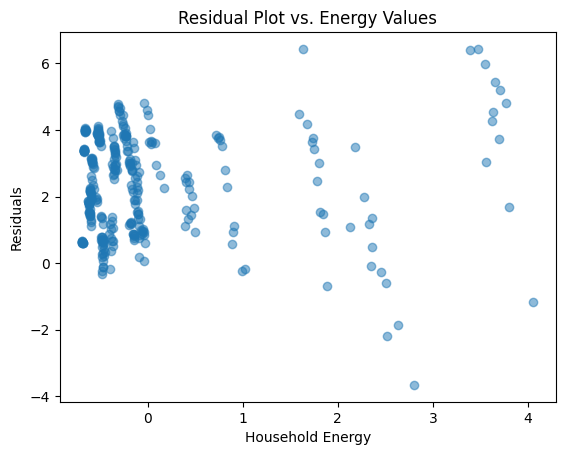

In [65]:
# x values versus residuals
plt.scatter(X[:, 1:2], res, alpha=0.5)
plt.xlabel("Household Energy")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Energy Values")
plt.show()

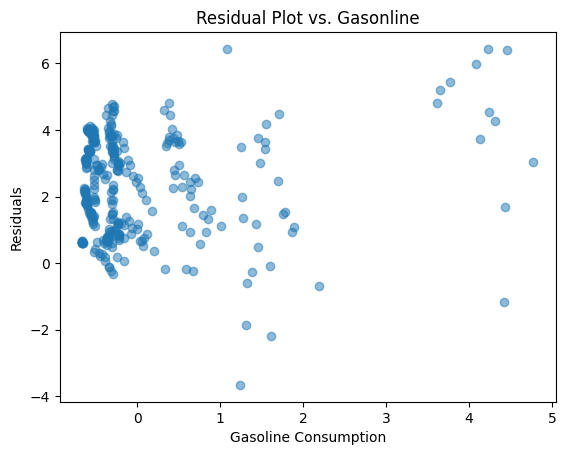

In [66]:
# x values versus residuals
plt.scatter(X[:, 2:3], res, alpha=0.5)
plt.xlabel("Gasoline Consumption")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Gasonline")
plt.show()

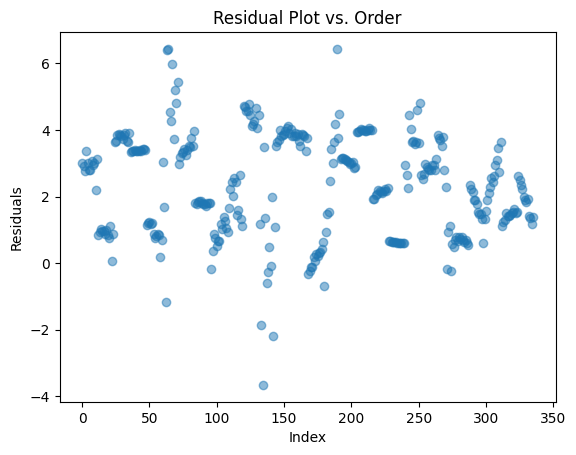

In [48]:
# residuals versus order
plt.scatter(range(len(X[:,1:2])), res, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [49]:
px.scatter_3d(df_merged_s, y="carbon", x="household_total", z="gas", color="geo")

In [50]:
import matplotlib.cm as cm

Text(0, 0.5, 'Greenhouse Emissions (ktonnes)')

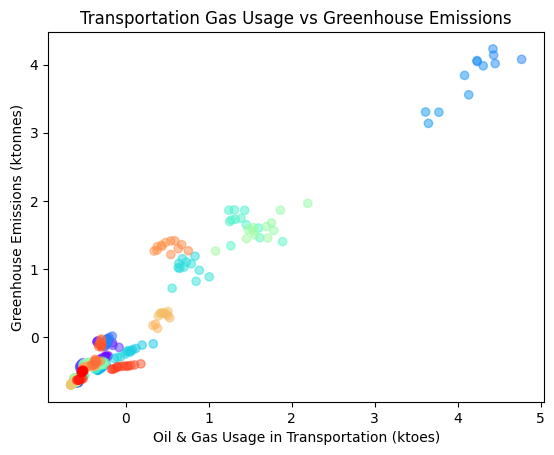

In [71]:
colors = cm.rainbow(np.linspace(0, 1, len(df_merged_s)))
plt.scatter(x=df_merged_s["gas"], y=df_merged_s["carbon"], color=colors, alpha=0.5)
plt.title("Transportation Gas Usage vs Greenhouse Emissions")
plt.xlabel("Oil & Gas Usage in Transportation (ktoes)")
plt.ylabel("Greenhouse Emissions (ktonnes)")

In [52]:
from sklearn.metrics import r2_score

In [53]:
from numpy.linalg import det

In [60]:
np_remove = lambda a, i: np.concatenate([a[:i,], a[i + 1:,]])
lin_reg = lambda X, Y: np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, Y))

def loo_cv_pred(X, Y):
	"""
	Predict Y values using leave one out cross validation

	:param X: The X features array (including bias column)
	:param Y: The true Y values
	:return: An array of the predicted Y-Vals
	"""
	y_pred = []
	for i in range(len(X)):
		holdout_X = X[i]
		
		loo_X = np_remove(X, i)
		loo_y = np_remove(Y, i)
		loo_b = lin_reg(loo_X, loo_y)

		y_hat = np.matmul(holdout_X, loo_b)
		y_pred.append(y_hat)
	
	return y_pred

In [61]:
preds = loo_cv_pred(X, y)
preds

(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,)
(31,

[9.312309954476866,
 -3.319029950308874,
 0.40936063240213016,
 -1.2318379599422562,
 -1.6296754835627567,
 -6.116470823215938,
 0.7901643333450394,
 2.6185385994553063,
 1.1634322574345237,
 0.8232133710834137,
 0.3000635551722315,
 -2.761932447995645,
 -0.06367480474389842,
 5.026412885412768,
 -7.231512982910489,
 -0.43386834078451253,
 1.844479083633165,
 8.13620446791802,
 -14.886636570200494,
 -2.7958639423266707,
 6.109786577763444,
 1.2671627819990139,
 -4.776989436113844,
 -1.7122694229302322,
 26.986701934447353,
 -7.493957212583879,
 -0.28498263627614584,
 1.2836118948656443,
 2.520208382140652,
 2.1589159692433135,
 0.939576871096933,
 -11.29382841027843,
 -0.5342812935414614,
 1.0123551457640687,
 -22.539435302470906,
 8.787757817567584,
 -1.038344681643749,
 -22.824815211174595,
 -26.423034750581166,
 2.400762019210572,
 2.1918197644724273,
 -10.2061297722217,
 -2.219064538014134,
 1.440897554066325,
 -1.151874502207284,
 -4.21866958827294,
 -0.9008863131155858,
 -32.8284

In [56]:
y

array([-0.27723402, -0.29177478, -0.29010731, -0.30864156, -0.29642375,
       -0.29061725, -0.27897853, -0.29450823, -0.28658073, -0.32742065,
       -0.30926046, -0.32874506, -0.05559046, -0.07163672, -0.07229433,
       -0.10074666, -0.07708621, -0.08533471, -0.08568578, -0.08009152,
       -0.08555847, -0.14156679, -0.12239963, -0.15284303, -0.37748343,
       -0.40394797, -0.43165662, -0.41621139, -0.39966733, -0.41268404,
       -0.40297752, -0.42529177, -0.43227202, -0.46509686, -0.43328907,
       -0.41008338, -0.66349004, -0.66639771, -0.67032842, -0.66840091,
       -0.66829008, -0.6654112 , -0.66391396, -0.66423755, -0.66403264,
       -0.66960282, -0.66737048, -0.66588213,  0.01337361, -0.007411  ,
       -0.03598398, -0.0472147 , -0.03871345, -0.030544  , -0.0258242 ,
       -0.03461044, -0.06498662, -0.12433246, -0.09589036, -0.10309541,
        4.07738829,  4.13992736,  4.23026902,  4.01556257,  4.05897024,
        4.04517657,  3.98246927,  3.84168823,  3.55647527,  3.13

In [57]:
r2_score(y, preds)

-4476.691935155938

In [58]:
(y - preds).mean()

-4.195576792520727

# Experiment: Model per country

In [38]:
df_be = df_merged_s.loc[df_merged_s["geo"] == "BE"]
df_be.head()

,carbon,energy_heating,energy_cooling,energy_water_heating,energy_cooking,total,gas,geo
0,-0.05559,0.057893,-0.567774,-0.197473,-0.477695,-0.03357,-0.334876,BE
1,-0.071637,0.050019,-0.549232,-0.19523,-0.477826,-0.03976,-0.343867,BE
2,-0.072294,0.042145,-0.53069,-0.192987,-0.477957,-0.045951,-0.344464,BE
3,-0.100747,0.03427,-0.512148,-0.190744,-0.478088,-0.052141,-0.319062,BE
4,-0.077086,0.026396,-0.493606,-0.188501,-0.478219,-0.058331,-0.296207,BE


In [39]:
X_be = np.array(np.pad(df_be.iloc[:, 5:6].to_numpy(), ((0,0), (1,0)), mode="constant", constant_values=1), dtype=np.float64)
y_be = np.array(df_be["carbon"])
X_be[0:2,]

array([[ 1.        , -0.03356972],
       [ 1.        , -0.03976014]])

In [40]:
beta_be = lin_reg(X_be, y_be)

In [41]:
res_be = y_be - np.matmul(X_be, beta_be)
print(res_be[0:5])
round(sum(res_be), 1)

[0.015930055989496518 0.00401391599181232 0.007486432925308192
 -0.016835780983615864 0.010954800460627176]


0.0

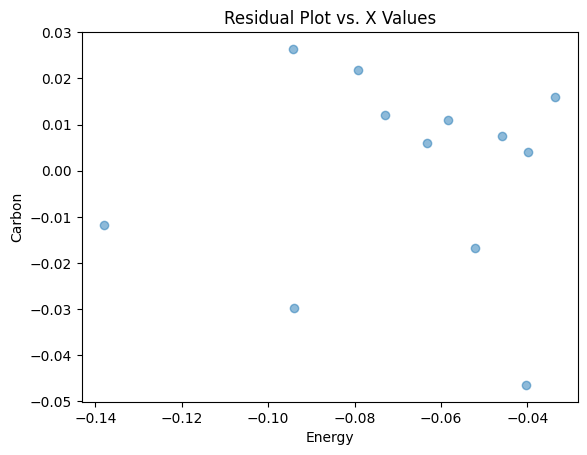

In [42]:
# x values versus residuals
plt.scatter(X_be[:, 1:2], res_be, alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Carbon")
plt.title("Residual Plot vs. X Values")
plt.show()

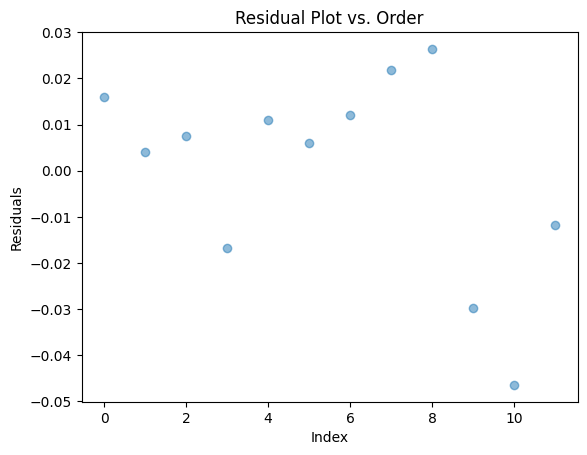

In [43]:
# residuals versus order
plt.scatter(range(len(X_be[:,1:2])), res_be, alpha=0.5)
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot vs. Order")
plt.show()

In [44]:
px.scatter(df_be, x="total", y="carbon")

In [45]:
preds_be = loo_cv_pred(X_be, y_be)

In [46]:
r2_score(y_be, preds_be)

0.19603744250668642